Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [3]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [5]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

##### First, L2 regularization for *logistic regression* model.

The multinomial logistic regression model with stochastic gradient descent is adapted from assignment 2:2_fullyconnected.ipynb


In [6]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():
    '''
    Input data. For the training data, we use a placeholder that will be fed
    at run time with a training minibatch.  
    '''
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta = tf.placeholder(tf.float32)  # Learning rate for regularization
    
    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) + 
                          beta * tf.nn.l2_loss(weights))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run it:

In [7]:
num_steps = 3000

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps+1):
        '''
        Pick an offset within the training data, which has been randomized.
        Note: we could use better randomization across epochs.
        '''
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        '''
        Prepare a dictionary telling the session where to feed the minibatch.
        The key of the dictionary is the placeholder node of the graph to be fed,
        and the value is the numpy array to feed to it.
        '''
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta: 0.01}  # Use 0.01 for beta
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 48.784027
Minibatch accuracy: 13.3%
Validation accuracy: 19.9%
Minibatch loss at step 500: 0.741133
Minibatch accuracy: 85.9%
Validation accuracy: 81.6%
Minibatch loss at step 1000: 0.799713
Minibatch accuracy: 80.5%
Validation accuracy: 81.3%
Minibatch loss at step 1500: 0.566128
Minibatch accuracy: 83.6%
Validation accuracy: 81.1%
Minibatch loss at step 2000: 0.648393
Minibatch accuracy: 88.3%
Validation accuracy: 81.2%
Minibatch loss at step 2500: 0.782520
Minibatch accuracy: 78.9%
Validation accuracy: 81.1%
Minibatch loss at step 3000: 0.784389
Minibatch accuracy: 80.5%
Validation accuracy: 81.4%
Test accuracy: 88.6%


Recall from assignment 2 that the final result without regularization is:

###### Minibatch loss at step 3000: *1.061334*
###### Minibatch accuracy: *77.3%*
###### Validation accuracy: *79.0%*
###### Test accuracy: *86.4%*

Now let's try different values for beta:

In [8]:
num_steps = 3000
beta_values = [pow(10, i) for i in np.arange(-4, -1, 0.1)] # from 0.0001 to 0.1
results = np.zeros(len(beta_values))

for i, beta_value in enumerate(beta_values):
    
    with tf.Session(graph=graph) as session:
        
        tf.initialize_all_variables().run()        
        for step in range(num_steps+1):
            
            '''
            Pick an offset within the training data, which has been randomized.
            Note: we could use better randomization across epoch
            '''
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            '''
            Prepare a dictionary telling the session where to feed the minibatch.
            The key of the dictionary is the placeholder node of the graph to be fed,
            and the value is the numpy array to feed to it.
            '''
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : beta_value}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            
        results[i] = accuracy(test_prediction.eval(), test_labels)
        # Print the progress
        if(i%5 == 0):
            print('%.1f%% finished' %(100*i/len(beta_values)))
print('Done!')

0.0% finished
16.0% finished
33.0% finished
50.0% finished
66.0% finished
83.0% finished
Done!


Let's plot the result:

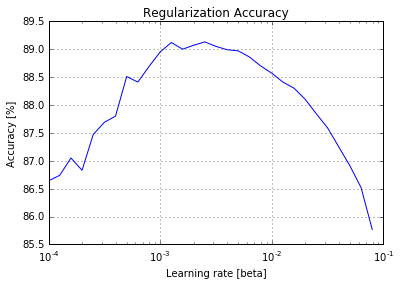

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.semilogx(beta_values, results)
plt.xlabel('Learning rate [beta]')
plt.ylabel('Accuracy [%]')
plt.grid(True)
plt.title('Regularization Accuracy')
plt.show()


##### Second, L2 regularization for *neural network* model.

In [10]:
batch_size = 128
hidden_nodes_size = 1024   # This is the number of the nodes in the hidden layer

graph = tf.Graph()
with graph.as_default():
    '''
    Input data. For the training data, we use a placeholder that will be fed
    at run time with a training minibatch.  
    '''
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta = tf.placeholder(tf.float32)  # Learning rate for regularization
    
    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes_size]))
    biases1 = tf.Variable(tf.zeros([hidden_nodes_size]))
    weights2 = tf.Variable(tf.truncated_normal([hidden_nodes_size, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    logits = tf.matmul(tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1), weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) + 
                          beta * tf.nn.l2_loss(weights1) + 
                          beta * tf.nn.l2_loss(weights2))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    valid_hidden = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(valid_hidden, weights2) + biases2)
    
    test_hidden = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(test_hidden, weights2) + biases2)

Let's run it:

In [11]:
num_steps = 3000
beta_value = 0.01

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps+1):
        '''
        Pick an offset within the training data, which has been randomized.
        Note: we could use better randomization across epochs.
        '''
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        '''
        Prepare a dictionary telling the session where to feed the minibatch.
        The key of the dictionary is the placeholder node of the graph to be fed,
        and the value is the numpy array to feed to it.
        '''
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta: beta_value}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3499.299561
Minibatch accuracy: 12.5%
Validation accuracy: 27.9%
Minibatch loss at step 500: 21.148560
Minibatch accuracy: 88.3%
Validation accuracy: 84.6%
Minibatch loss at step 1000: 0.944835
Minibatch accuracy: 81.2%
Validation accuracy: 83.1%
Minibatch loss at step 1500: 0.576774
Minibatch accuracy: 85.9%
Validation accuracy: 83.5%
Minibatch loss at step 2000: 0.608200
Minibatch accuracy: 90.6%
Validation accuracy: 83.4%
Minibatch loss at step 2500: 0.715497
Minibatch accuracy: 83.6%
Validation accuracy: 83.5%
Minibatch loss at step 3000: 0.767823
Minibatch accuracy: 82.8%
Validation accuracy: 83.3%
Test accuracy: 90.3%


Recall from assignment 2 that the final result without regularization is:

###### Minibatch loss at step 3000: *1.388752*
###### Minibatch accuracy: *82.0%*
###### Validation accuracy: *81.7%*
###### Test accuracy: *88.8%*

Try different values for beta is very slow for neural network.
TODO: try to make it faster

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [14]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():
    '''
    Input data. For the training data, we use a placeholder that will be fed
    at run time with a training minibatch.  
    '''
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta = tf.placeholder(tf.float32)  # Learning rate for regularization
    
    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) + 
                          beta * tf.nn.l2_loss(weights))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [19]:
num_steps = 3000
beta_value = 0.0  # No regularization shows overfitting even more obviously
num_batch = 5     # Limit of the number of batches

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps+1):
        '''
        Pick an offset within the training data, which has been randomized.
        Note: we could use better randomization across epochs.
        '''
        
        # "step % num_batch" limits the training set to the same batches over and over again
        offset = ( (step % num_batch) * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        '''
        Prepare a dictionary telling the session where to feed the minibatch.
        The key of the dictionary is the placeholder node of the graph to be fed,
        and the value is the numpy array to feed to it.
        '''
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta: beta_value}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 19.329138
Minibatch accuracy: 10.2%
Validation accuracy: 10.2%
Minibatch loss at step 500: 0.119919
Minibatch accuracy: 97.7%
Validation accuracy: 67.8%
Minibatch loss at step 1000: 0.029164
Minibatch accuracy: 100.0%
Validation accuracy: 69.0%
Minibatch loss at step 1500: 0.016403
Minibatch accuracy: 100.0%
Validation accuracy: 69.5%
Minibatch loss at step 2000: 0.011571
Minibatch accuracy: 100.0%
Validation accuracy: 69.7%
Minibatch loss at step 2500: 0.008998
Minibatch accuracy: 100.0%
Validation accuracy: 69.9%
Minibatch loss at step 3000: 0.007388
Minibatch accuracy: 100.0%
Validation accuracy: 70.0%
Test accuracy: 77.7%


###### Discussion:
By limiting the training batch numbers to a small number and getting rid of regularization,
overfitting is pretty obvious.
The training accuracy goes to 100% but not too well for validation and test datasets.
That's because the training algorithm is overfitting the training dataset and not general
enough for other datasets.


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [24]:
batch_size = 128
hidden_nodes_size = 1024   # This is the number of the nodes in the hidden layer

graph = tf.Graph()
with graph.as_default():
    '''
    Input data. For the training data, we use a placeholder that will be fed
    at run time with a training minibatch.  
    '''
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta = tf.placeholder(tf.float32)  # Learning rate for regularization
    keep_prob = tf.placeholder(tf.float32)
    
    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes_size]))
    biases1 = tf.Variable(tf.zeros([hidden_nodes_size]))
    weights2 = tf.Variable(tf.truncated_normal([hidden_nodes_size, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    # "relu" before "dropout"
    layer1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    drop_out = tf.nn.dropout(layer1, keep_prob)
    logits = tf.matmul(drop_out, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) + 
                          beta * tf.nn.l2_loss(weights1) + 
                          beta * tf.nn.l2_loss(weights2))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    valid_hidden = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(valid_hidden, weights2) + biases2)
    
    test_hidden = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(test_hidden, weights2) + biases2)

In [25]:
num_steps = 3000
beta_value = 0.01

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps+1):
        '''
        Pick an offset within the training data, which has been randomized.
        Note: we could use better randomization across epochs.
        '''
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        '''
        Prepare a dictionary telling the session where to feed the minibatch.
        The key of the dictionary is the placeholder node of the graph to be fed,
        and the value is the numpy array to feed to it.
        '''
        feed_dict = {tf_train_dataset : batch_data, 
                     tf_train_labels : batch_labels, 
                     beta: beta_value,
                     keep_prob: 0.5}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3593.848145
Minibatch accuracy: 12.5%
Validation accuracy: 23.7%
Minibatch loss at step 500: 21.356874
Minibatch accuracy: 86.7%
Validation accuracy: 84.0%
Minibatch loss at step 1000: 1.014751
Minibatch accuracy: 82.0%
Validation accuracy: 83.0%
Minibatch loss at step 1500: 0.654728
Minibatch accuracy: 85.9%
Validation accuracy: 83.1%
Minibatch loss at step 2000: 0.669211
Minibatch accuracy: 86.7%
Validation accuracy: 83.0%
Minibatch loss at step 2500: 0.755356
Minibatch accuracy: 83.6%
Validation accuracy: 82.7%
Minibatch loss at step 3000: 0.853770
Minibatch accuracy: 82.8%
Validation accuracy: 83.0%
Test accuracy: 90.0%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


Try with 2 layers and decay learning rate:

In [68]:
batch_size = 128
# Try two layers
hidden_nodes_size1 = 1024
hidden_nodes_size2 = 100  

graph = tf.Graph()
with graph.as_default():
    '''
    Input data. For the training data, we use a placeholder that will be fed
    at run time with a training minibatch.  
    '''
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta = tf.placeholder(tf.float32)  # Learning rate for regularization
    keep_prob = tf.placeholder(tf.float32)
    global_step = tf.Variable(0)
    
    # Variables.
    # Need to specify a small stddev, otherwise won't converge
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes_size1],
                                               stddev=np.sqrt(2.0 / (image_size * image_size))))
    biases1 = tf.Variable(tf.zeros([hidden_nodes_size1]))
    weights2 = tf.Variable(tf.truncated_normal([hidden_nodes_size1, hidden_nodes_size2],
                                               stddev=np.sqrt(2.0 / (image_size * image_size))))
    biases2 = tf.Variable(tf.zeros([hidden_nodes_size2]))
    weights3 = tf.Variable(tf.truncated_normal([hidden_nodes_size2, num_labels],
                                              stddev=np.sqrt(2.0 / (image_size * image_size))))
    biases3 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    layer1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    # drop_out1 = tf.nn.dropout(layer1, keep_prob)     #dropout actually made it worse
    layer2 = tf.nn.relu(tf.matmul(layer1, weights2) + biases2)
    #drop_out2 = tf.nn.dropout(layer2, keep_prob)
    logits = tf.matmul(layer2, weights3) + biases3
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) + 
                          beta * tf.nn.l2_loss(weights1) + 
                          beta * tf.nn.l2_loss(weights2) + 
                          beta * tf.nn.l2_loss(weights3))

    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.8, staircase = True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step = global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    valid_hidden1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_hidden2 = tf.nn.relu(tf.matmul(valid_hidden1, weights2) + biases2)
    valid_prediction = tf.nn.softmax(tf.matmul(valid_hidden2, weights3) + biases3)
    
    test_hidden1 = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_hidden2 = tf.nn.relu(tf.matmul(test_hidden1, weights2) + biases2)
    test_prediction = tf.nn.softmax(tf.matmul(test_hidden2, weights3) + biases3)

In [70]:
num_steps = 3000
beta_value = 0.01

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps+1):
        '''
        Pick an offset within the training data, which has been randomized.
        Note: we could use better randomization across epochs.
        '''
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        '''
        Prepare a dictionary telling the session where to feed the minibatch.
        The key of the dictionary is the placeholder node of the graph to be fed,
        and the value is the numpy array to feed to it.
        '''
        feed_dict = {tf_train_dataset : batch_data, 
                     tf_train_labels : batch_labels, 
                     beta: beta_value,
                     keep_prob: 0.75}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 11.216919
Minibatch accuracy: 7.0%
Validation accuracy: 30.2%
Minibatch loss at step 500: 0.699115
Minibatch accuracy: 87.5%
Validation accuracy: 83.3%
Minibatch loss at step 1000: 0.841523
Minibatch accuracy: 79.7%
Validation accuracy: 83.3%
Minibatch loss at step 1500: 0.608489
Minibatch accuracy: 87.5%
Validation accuracy: 84.2%
Minibatch loss at step 2000: 0.625564
Minibatch accuracy: 91.4%
Validation accuracy: 84.0%
Minibatch loss at step 2500: 0.743373
Minibatch accuracy: 84.4%
Validation accuracy: 84.1%
Minibatch loss at step 3000: 0.780745
Minibatch accuracy: 82.8%
Validation accuracy: 84.2%
Test accuracy: 91.2%
